Before running the script, go to the toolbar above and select:

    Runtime → Change Runtime type → Hardware accelerator → GPU

After the runtime has been changed, the necessary dependencies need to be downloaded.

In [1]:
%load_ext autoreload
%autoreload 2

# Install dependencies
!pip install snakemake tqdm torch simpleitk albumentations -U -q

     |████████████████████████████████| 256kB 4.7MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 44.9MB 68kB/s 
     |████████████████████████████████| 122kB 62.5MB/s 
     |████████████████████████████████| 40.6MB 75kB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 552kB 47.1MB/s 
     |████████████████████████████████| 163kB 58.3MB/s 
     |████████████████████████████████| 952kB 49.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 12.1MB/s 


Next, the bootstrap2.5d directory will be downloaded and the directories for the model's inputs and outputs will be created. 

In [2]:
# Designate path of bootstrap2.5d directory
# Change to /content/drive/My Drive/bootstrap2.5d if downloading to Google Drive
boot_dir = "/content/bootstrap2.5d"

# Clone repository
!mkdir ..{boot_dir}
!git clone --single-branch --branch colab https://github.com/volume-em/bootstrap2.5d.git ..{boot_dir}

# Create directories
!cd {boot_dir}; \
  mkdir -p models; \
  mkdir -p data; \
    mkdir -p data/train; \
      mkdir -p data/train/images; \
      mkdir -p data/train/masks; \
    mkdir -p data/target; \
      mkdir -p data/target/images;

Cloning into '../content/bootstrap2.5d'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 168 (delta 89), reused 110 (delta 44), pack-reused 0
Receiving objects: 100% (168/168), 81.94 KiB | 7.45 MiB/s, done.
Resolving deltas: 100% (89/89), done.


The repository has been cloned and the necessary directories have been created, now datasets can be added. To upload data, click the folder icon to the left. From there files can be added via:

1. Dragging files from your local file browser into colab
2. Right clicking on a folder in colab and pressing upload
3. Pressing "Mount Drive" at the top of the files tab. This will allow you to access files from your Google Drive in Colab. Files uploaded to Colab runtimes are deleted when sessions end, for permanent storage the bootstrap2.5d repository should be downloaded directly to your Google Drive. Alternatively, if the repo is downloaded to the runtime's temporary storage one can click and drag files into Drive.

In this example, we are downloading data from the paper [Automatic segmentation of mitochondria and endolysosomes in volumetric electron microscopy data](https://www.sciencedirect.com/science/article/abs/pii/S0010482520300792?via%3Dihub). This dataset contains training volumes with segmented mitochondria and lysosomes. Because the organelles are segmented in separate files, we have to combine them in the cell below.



In [3]:
from glob import glob
import SimpleITK as sitk
from matplotlib import pyplot as plt
import numpy as np

# Download files
!cd bootstrap2.5d; bash download_examples.sh 

data_dir = f"{boot_dir}/data"

# Get paths of the mito and lyso labelmap volumes
lysopaths = np.sort(glob(f"{data_dir}/train/masks/lyso/*.nii.gz"))
mitopaths = np.sort(glob(f"{data_dir}/train/masks/mito/*.nii.gz"))

# Make sure the training and target images are uint8
imagpaths = glob(f"{data_dir}/train/images/*.nii.gz") + glob(f"{data_dir}/target/images/*.nii.gz")
[sitk.WriteImage(sitk.Cast(sitk.ReadImage(im), sitk.sitkUInt8), im) for im in imagpaths]

for lp, mp in zip(lysopaths, mitopaths):
    assert(lp.replace('/lyso/', '/mito/') == mp), "Lyso and mito label volumes are not aligned!"

    # Load the volumes
    lyso = sitk.ReadImage(lp)
    mito = sitk.ReadImage(mp)
    
    # Add them together into a single label volume such that 1 == lyso & 2 == mito
    labelmap = lyso + 2 * mito
    
    # Make sure the datatype is uint8
    labelmap = sitk.Cast(labelmap, sitk.sitkUInt8)

    # Save the result
    sitk.WriteImage(labelmap, lp.replace('lyso/', ''))

# Remove lyso and mito directories
!rm -r "{data_dir}/train/masks/lyso"
!rm -r "{data_dir}/train/masks/mito"

Now that the dataset has been downloaded, we can visualize what our training volumes and masks look like.

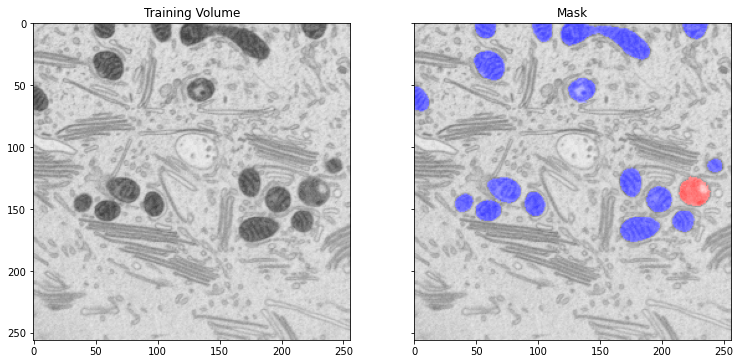

In [4]:
%matplotlib inline

def gray_to_RGB(img_array):
  "Convert an 8bit grayscale image to RGB"
  return np.concatenate(3 * [img_array[..., np.newaxis]], axis=-1)

def labelmap_to_RGB(img_array):
  "Convert a 2 or 3-class labelmap to RGB"
  black = img_array[..., np.newaxis] * 0 * np.array([0, 0, 0])
  red = img_array[..., np.newaxis] % 2 * np.array([255, 0, 0])
  blue = img_array[..., np.newaxis] // 2 * np.array([0, 0, 255])
  return black + red + blue

# Take one 2D slice of a 3D volume
slice_index = 125

# Load image into memory
train_image = sitk.GetArrayFromImage(sitk.ReadImage(glob(f"{data_dir}/train/images/*.nii.gz")[0]))
train_image_slice = gray_to_RGB(train_image[slice_index])

# Combine mask image and training volume image
mask = sitk.GetArrayFromImage(sitk.ReadImage(glob(f"{data_dir}/train/masks/*.nii.gz")[0]))
mask_slice = np.clip(train_image_slice + labelmap_to_RGB(mask[slice_index]), 0, 255)

# Display plots
figure, axes = plt.subplots(1, 2, sharey = True, figsize=(12.5, 12.5))
for ax, i, t in zip(axes, (train_image_slice, mask_slice), ['Training Volume', 'Mask']):
  ax.imshow(i)
  ax.set_title(t)

Text files can be edited directly in Colab by double clicking them in the file browser. This would be the easiest way to make changes to the Snakefile. In this example the process of changing hyperparameters is automated by opening and writing to the file with Python.

In [5]:
with open(f'{boot_dir}/Snakefile', 'r+') as snake:
  lines = snake.readlines()
  lines[44] = lines[44].replace(
      'N_CLASSES = 1',
      "N_CLASSES = 3"
  )
  snake.seek(0); snake.truncate() # Clear before writing
  snake.writelines(lines)

Now the pipeline can be run using Snakemake.

In [6]:
!cd {boot_dir}; snakemake --cores all 

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 2
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	all
	1	orthoplane_inf_supervised
	1	orthoplane_inf_weakly_supervised
	1	target_data_to_patches
	1	train_data_to_patches
	1	train_supervised
	1	train_weakly_supervised
	7

[Mon Sep 28 20:04:29 2020]
rule train_data_to_patches:
    input: data/train/images/, data/train/masks/
    output: data/train2d/, data/valid2d/
    jobid: 5

Saved 427 images for validation dataset.
[Mon Sep 28 20:04:42 2020]
Finished job 5.
1 of 7 steps (14%) done

[Mon Sep 28 20:04:42 2020]
rule train_supervised:
    input: data/train2d/
    output: models/supervised.pth
    jobid: 3

Found 2633 images in data/train2d/images
Found 427 images in data/valid2d/images
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100% 83.3M/83.3M [00:00<00:00, 200MB/s]
Froze resnet weights before layer4. Using m

Now that predictions have been made, we can visualize how the two algorithms performed.

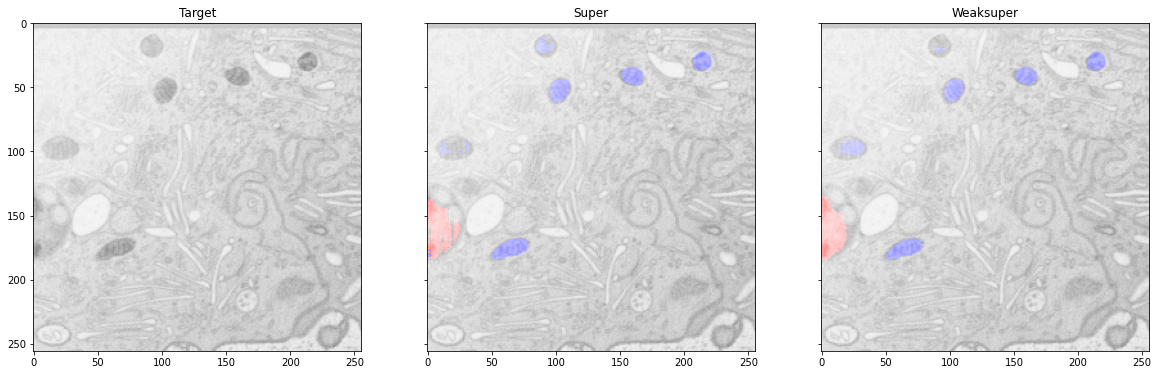

In [7]:
target_image = sitk.GetArrayFromImage(sitk.ReadImage(glob(f"{data_dir}/target/images/*.nii.gz")[0]))
img_slice = gray_to_RGB(target_image[slice_index])

super_pred = sitk.GetArrayFromImage(sitk.ReadImage(glob(f"{data_dir}/target/super_preds/*.nii.gz")[0]))
super_pred_slice = np.clip(img_slice + labelmap_to_RGB(super_pred[slice_index]), 0, 255)

weak_super = sitk.GetArrayFromImage(sitk.ReadImage(glob(f"{data_dir}/target/weaksuper_preds/*.nii.gz")[0]))
weak_super_pred_slice = np.clip(img_slice + labelmap_to_RGB(weak_super[slice_index]), 0, 255)

figure, axs = plt.subplots(1, 3, sharey = True, figsize=(20, 20))
for ax, im, t in zip(axs, (img_slice, super_pred_slice, weak_super_pred_slice), ['Target', 'Super', 'Weaksuper']):
  ax.imshow(im)
  ax.set_title(t)